In [2]:
import subprocess
subprocess.check_output(["pip", "install", "nltk"])

subprocess.check_output(["python", "-m", "nltk.downloader", "all"])

b''

In [3]:
%pylab inline
import msgpack
import nltk
import sklearn.cluster
import message
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import time
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


In [4]:
with open("/home/jovyan/ymslanda/supportnlp/tickets/all_tickets_and_comments.msgpack", "rb") as f:
    data = msgpack.load(f, raw=False)

with open("/home/jovyan/ymslanda/supportnlp/tickets/all_tickets_fields.msgpack", "rb") as f:
    ticketfields = msgpack.load(f, raw=False)
    
with open("stopwords.msgpack", "rb") as f:
    stop_words = msgpack.load(f)
stop_words = set(stop_words).union(stopwords.words('english')).union(stopwords.words('norwegian'))

In [6]:
msgfreq = {}
for org in data.values():
    for ticket in org.values():
        for word in message.message(ticket["description"] + "  " + ticket["subject"], stopwords).dict:
            if word not in msgfreq: msgfreq[word] = 0
            msgfreq[word] += 1

In [7]:
orderedmsgfreq = sorted((freq, word) for (word, freq) in msgfreq.items())

In [17]:
msgs = []
for orgid, org in data.items():
    for ticketid, ticket in org.items():
        m = message.message(ticket["description"] + "  " + ticket["subject"], stopwords)
        m.orgid = orgid
        m.ticketid = ticketid
        msgs.append(m)

## Possible distance measure between tickets for use in clustering
Currently not used :(

In [26]:
conn = np.zeros((len(msgs), len(msgs)))
for ai, a in enumerate(msgs):
    for bi, b in enumerate(msgs):
        conn[ai,bi] = len(a.dict.intersection(b.dict)) / len(a.dict.union(b.dict))

ticketids = np.array(list(msg.ticketid for msg in msgs), dtype="i")

np.savez_compressed("connectivity_iou_description_subject.npz", ticketids=ticketids, conn=conn)

## Cluster tickets

In [231]:

def tickets():
    for org in data.values():
        for ticket in org.values():
            if ticket["subject"] in ("SQLdump",):
                continue
            if len(ticket["description"]) > 1000:
                continue
            yield ticket

tickets = list(tickets())
tickettexts = [re.sub("(\\w)://(\\w)", "\\1URL\\2",
                      re.sub("(\\w):(\\w)", "\\1COLON\\2",
                             re.sub("(\\w)/(\\w)", "\\1SLASH\\2",
                                    re.sub("(\\w)\\.(\\w)", "\\1DOT\\2",
                                         ("%(subject)s %(description)s" % ticket)))))
              for ticket in tickets]

In [232]:
vectorizer = TfidfVectorizer(use_idf=False, stop_words=stop_words)
X = vectorizer.fit_transform(tickettexts)

n_clusters = 100
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=1,
            verbose=True)
    
print("Clustering sparse data with %s" % km)
t0 = time.time()
km.fit(X)
print("done in %0.3fs" % (time.time() - t0))
print()


#print("Top terms per cluster:")
#
#order_centroids = km.cluster_centers_.argsort()[:, ::-1]
#
#terms = vectorizer.get_feature_names()
#for i in range(n_clusters):
#    print("Cluster %d:" % i, end='')
#    for ind in order_centroids[i, :10]:
#        print(' %s' % terms[ind], end='')
#    print()


Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=100, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)
Initialization complete
Iteration  0, inertia 1511.999
Iteration  1, inertia 892.579
Iteration  2, inertia 880.993
Iteration  3, inertia 876.778
Iteration  4, inertia 874.939
Iteration  5, inertia 874.073
Iteration  6, inertia 873.546
Iteration  7, inertia 873.265
Iteration  8, inertia 873.196
Converged at iteration 8: center shift 0.000000e+00 within tolerance 8.372466e-09
done in 2.113s



In [233]:
clustering = km.predict(X)

In [234]:
clusterorder, clustercount = np.unique(clustering, return_counts=True)
srt = clustercount.argsort()
clusterorder = clusterorder[srt]
clustercount = clustercount[srt]

In [235]:
clusteredtickets = {}
for idx, ticket in enumerate(tickets):
    if clustering[idx] not in clusteredtickets:
        clusteredtickets[clustering[idx]] = []
    clusteredtickets[clustering[idx]].append(ticket)


## Some measures across all tickets

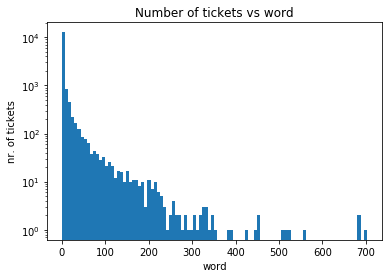

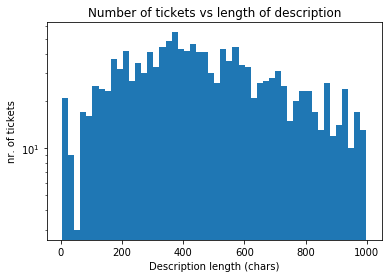

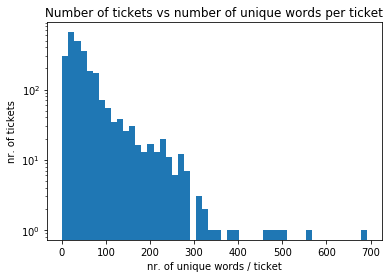

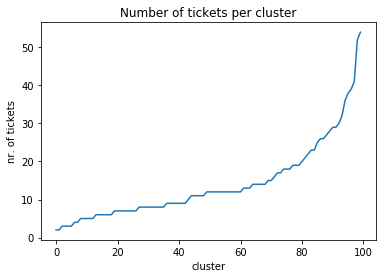

In [236]:
plt.hist(msgfreq.values(), log=True, bins=100)
plt.title("Number of tickets vs word")
plt.xlabel("word")
plt.ylabel("nr. of tickets")
plt.show()

plt.hist([len(ticket["description"]) for ticket in tickets], log=True, bins=50)
plt.title("Number of tickets vs length of description")
plt.xlabel("Description length (chars)")
plt.ylabel("nr. of tickets")
plt.show()

plt.hist([len(msg.dict) for msg in msgs], log=True, bins=50)
plt.title("Number of tickets vs number of unique words per ticket")
plt.xlabel("nr. of unique words / ticket")
plt.ylabel("nr. of tickets")
plt.show()

plt.plot(clustercount)
plt.title("Number of tickets per cluster")
plt.xlabel("cluster")
plt.ylabel("nr. of tickets")
plt.show()

## Cluster example messages (subject lines)

In [237]:
for clusterid in clusterorder[(clustercount > 25) & (clustercount < 70)]:
    print("Cluster %s" % clusterid)
    for t in clusteredtickets[clusterid][:10]:
        print("    %(subject)s" % t)

Cluster 48
    BW Lilac / Dualog+Compas
    Re: [Request ID :##75467##] : BW Lilac / Dualog+Compas
    190118-GAR - Request for Dualog password
    FW: [Request received] FW: crew password
    181106 - GAR - Dualog Password for Mr. Asuncion
    dualog register internet problem
    {SPAM?} ELBRUS -Reset Password for Crew
    change vsat and iridium in dualog/ possibility to swap over to iridium when we need, see what email is blocking the traffic, stop big email.
    Dualog Password - CK Michael Domingo
    Hafnia Africa - please reset password of new crew
Cluster 43
    vessel Name Change
    Email issue - Cielo di San Francisco
    Glenda Meryl - Dualog Backup OLD Folder
    Resend the emails.
    Allow URL's for D’Amico Fleet and Ishima Fleet
    Cielo Di Sanfrancisco Dualog email issue
    Cielo Di Rotterdam - IMAP Backup
    Reset password
    Glenda Meryl_IMAP backup
    Medi Serapo_IMAP BackUp
Cluster 21
    Columbia Highway
    Re: New Activation order: EOS Esperance under New C

## Most common words in descriptions

In [238]:
for f, word in orderedmsgfreq[-10:]:
    print(word, f)

crew 449
bridge 451
captain 455
vsat 509
mobile 516
http 526
phone 556
fax 682
fbb 686
tel 702
